# Python Document Search Engine

Now, we will start to put together all of the topics that we have studied so far into a series of "Python Recipes"---coding examples that illustrate the power of thinking hard about how data is organized and structured. In the first example, we will consider a "Python Search Engine" that will identify relevant items given a query string.

We're going to start with a dataset of tweets about airlines called "Twitter US Airline Sentiment".  It can be found on kaggle https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment.  The data is from February 2015, and was described by crowdflower as "A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as “late flight” or “rude service”)."

In [1]:
import csv

def load_data(filename):
    rtn = []
    #open the file with the csv reader
    with open(filename, newline='') as csvfile:
        tweets = csv.reader(csvfile, delimiter=',', quotechar='"') 
        next(tweets)#skip the header   
        for row in tweets:
            rtn.append(row[10])
    return rtn
    

tweets = load_data('Tweets.csv')

#figure out how much data we have
size = sum([i.__sizeof__() for i in tweets]) + tweets.__sizeof__()

print('Number: ', len(tweets), '\t Size:', size/1e6,'MB','\t Bytes per tweet:', size/len(tweets))

Number:  14640 	 Size: 2.54024 MB 	 Bytes per tweet: 173.5136612021858


In [19]:
import spacy
nlp = spacy.load("en_core_web_lg")


In [17]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 974.5 kB/s eta 0:00:0000:0100:08
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [21]:
import numpy as np
d = np.zeros(shape =(len(tweets), len(tweets)))

In [23]:
MAX = 1000
nlptweets = [ nlp(t) for t in tweets[0:MAX]] 

In [24]:
for i,t in enumerate(nlptweets[0:MAX]):
    if i%100 == 0 : 
        print (i)
    for j,t2 in enumerate(nlptweets[0:MAX]):
        d[i,j] = t.similarity(t2)

0
100
200
300
400
500
600
700
800
900


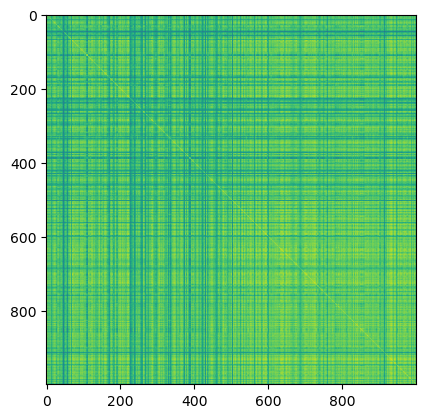

In [27]:
import matplotlib.pyplot as plt
plt.imshow(d[0:MAX, 0:MAX])

/Users/wltrimbl/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/wltrimbl/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


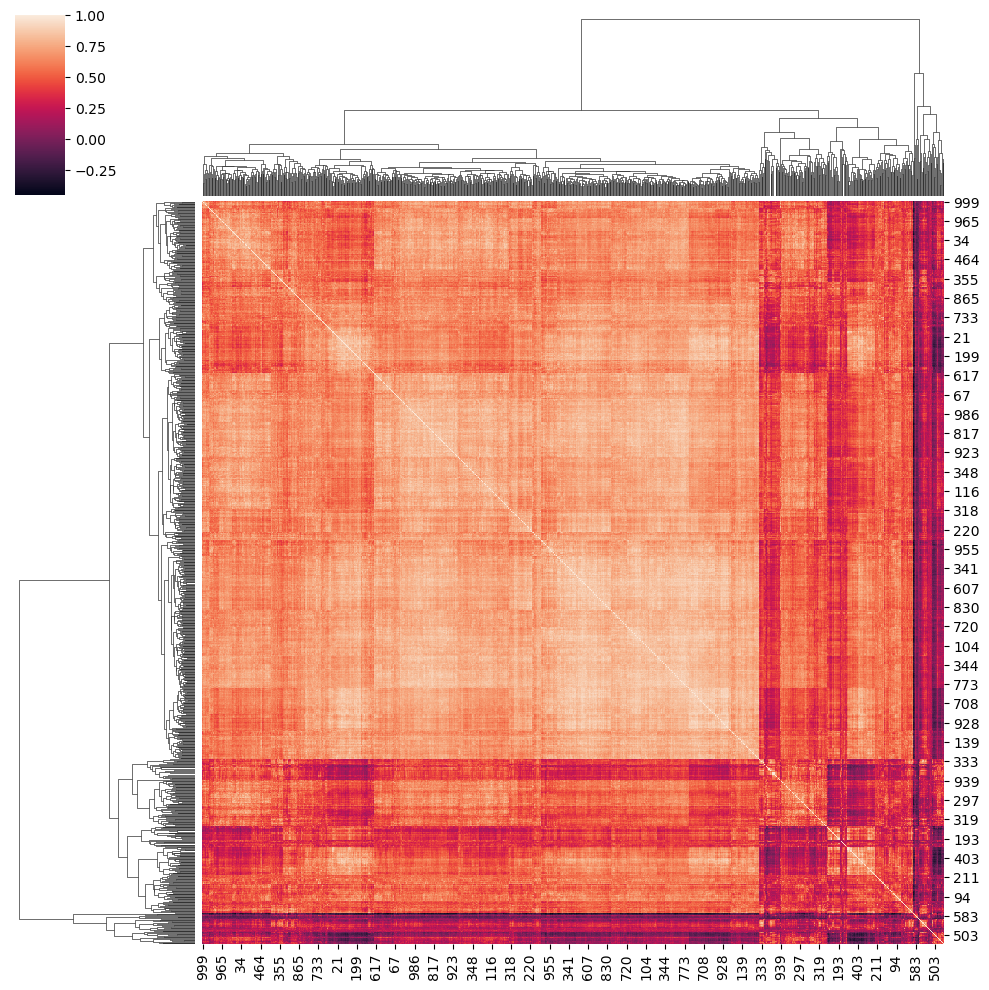

In [29]:
smalld = d[0:MAX, 0:MAX] 
import scipy
import seaborn as sns
sns.clustermap(smalld)

In [ ]:
!conda install -y seaborn scipy


(array([1.2000e+01, 2.6000e+01, 1.2000e+01, 3.4000e+01, 6.4000e+01,
        9.2000e+01, 9.6000e+01, 1.1600e+02, 1.1000e+02, 1.4400e+02,
        1.5600e+02, 1.8800e+02, 2.1200e+02, 2.5800e+02, 3.4400e+02,
        3.6800e+02, 4.3800e+02, 4.6800e+02, 4.8400e+02, 5.3800e+02,
        6.4800e+02, 7.4400e+02, 8.1800e+02, 8.5600e+02, 1.1080e+03,
        1.2260e+03, 1.2980e+03, 1.3720e+03, 1.4980e+03, 1.6140e+03,
        1.7380e+03, 1.7640e+03, 2.0280e+03, 2.1520e+03, 2.3040e+03,
        2.2920e+03, 2.5480e+03, 2.8040e+03, 3.0280e+03, 3.1940e+03,
        3.3800e+03, 3.6880e+03, 3.9320e+03, 4.3520e+03, 4.6540e+03,
        5.2220e+03, 5.7540e+03, 6.0140e+03, 6.5240e+03, 6.7300e+03,
        7.3080e+03, 8.1260e+03, 8.5980e+03, 9.5320e+03, 1.0036e+04,
        1.0664e+04, 1.1562e+04, 1.2162e+04, 1.2872e+04, 1.3728e+04,
        1.4432e+04, 1.5346e+04, 1.6038e+04, 1.6972e+04, 1.8152e+04,
        1.9170e+04, 2.0172e+04, 2.1350e+04, 2.2534e+04, 2.3794e+04,
        2.5476e+04, 2.7180e+04, 2.8380e+04, 3.01

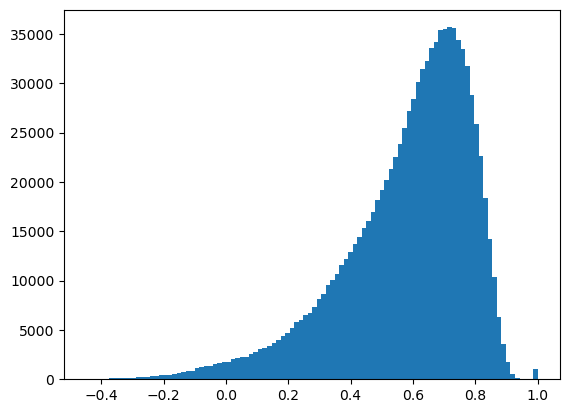

In [31]:
plt.hist(smalld.reshape(-1), bins=100)

In [ ]:

l

Notice that build_index is about a 100x slower than a single query. What does this mean? Basically, indexing is only valuable if you run a lot of queries! 

The next challenge is how to use an inverted index to answer general substring queries. In class, we showed how to do exact keyword lookup but the phrase 'choppy landing' is actually two words. This is actually not a problem, and we can use the inverted index to retrieve a set of candidates and then use the naive find method among just those candidates. <font color = red> Is this a good idea? </font>

So, let's write a new find function that can use this index:
* It splits the phrase into its constituent words
* Searches each word in the inverted index, finds a set of possibly relevant tweets (that match on a single word)
* Then double checks that set.
<font color=red>What kind of imperfection in the index are we working around here, false positives or false negatives?</font>

In [ ]:
def find_index(phrase, tweets, index):
    start = datetime.datetime.now()
    words = phrase.split()
    #find tweets that contain all words
    candidates = None
    
    for w in words: #for each words in the phrase
        try:
            if candidates is None:
                candidates = index[w] #return the set of tweets for w
            else:
                candidates = candidates.intersection(index[w])
        except KeyError:
            return []
    
    candidate_tweets = [tweets[ref] for ref in candidates]
    print("number of candidates", len(candidate_tweets)) 
    return find(phrase, candidate_tweets)
    print('find_index() elapsed time: ', (datetime.datetime.now()-start).total_seconds())
    
find_index('choppy landing', tweets, index)
#find_index('LAX', tweets, index)[:10]

In [ ]:
len(find_index('to Chicago', tweets, index))


In [ ]:
len(find_index('here again', tweets, index))

There is a bug here; the index used .translate() to remove punctuation from the tokens.  What kind of error will this mismatch between the query and the canonical form of the token in the index provoke?

In essence, you are paying a small upfront cost for greatly improved find performance (nearly a 1000x faster!). Speed is only aspect of search engine performance. We also like to support situations where a user mistypes a phrase. For example, if we mistype choppy landing:

In [ ]:
find_index('chopy landing', tweets, index)

In [ ]:
import re
len(index.keys())
for key in index.keys():
    if re.search("^ch.*y", key):
        print(key, len(index[key]))

Our system returns nothing. This is less than optimal.  How many approaches can we think of to handle mispellings?


## Did you mean? 
So now we are going to write a utility that can identify mispelling and typos and suggest potential alternatives. So let's start off with a naive approach that simply finds the closest word in the index in terms of edit distance:

In [ ]:
import distance

print( "Jaccard('a b', 'b c')=", distance.jaccard('a b', 'b c'))
print( "Levenshtein('a b', 'b c')=", distance.levenshtein('a b','b c') )

In [ ]:
def did_you_mean_naive(word, index):
    start = datetime.datetime.now()
    if word in index:
        return word
    else:
        distances = [(distance.levenshtein(word, iw), iw) for iw in index]
        distances.sort()
        print('did_you_mean_naive() elapsed time: ', (datetime.datetime.now()-start).total_seconds())
        return distances[0][1]

did_you_mean_naive('chopy', index)

In [ ]:
did_you_mean_naive('discont', index)

In [ ]:
did_you_mean_naive('dtg', index)

The suggestion utility runs much slower than the actual query!!! How do we fix this? We can use the same trick as before: a fast algorithm to find reasonable candidates and a slower algorithm to refine those candidates.

In fact, we will use an inverted index again. Just this time over sub-sequences of letters and not words. The first thing that we are going to do is to calculate n-grams these are contiguous sub-sequences of letters.

In [ ]:
#ngram
#def find_ngrams(word, n):
#    return list(zip(*[word[i:] for i in range(n)]))

def find_ngrams(word, n):
    '''digest a word (a string) into a list of len(word)-n+1 
    ngrams of length n.'''
    return [word[i:i+n] for i in range(0, len(word)-n+1)]

find_ngrams('dave', 2)

Next, we are going to build a "word" index, an indexing structure that maps ngrams to words that contain them.

In [ ]:
def build_word_index(index, n):
    '''Builds a dictionary that maps ngrams contained in the 
    keys of index to the keys themselves.'''
    start = datetime.datetime.now()  
    word_index = {}
    for word in index:
        ngrams = find_ngrams(word, n)     
        for subseq in ngrams:       
            if subseq not in word_index:
                word_index[subseq] = set()       
            word_index[subseq].add(word) #add a pointer to the relevant word
    
    print('build_word_index() elapsed time: ', (datetime.datetime.now()-start).total_seconds())
    return word_index

word_index = build_word_index(index, 3)
print(repr(word_index)[0:400])

We can use this word index to build a more sophisticated search:
* Only consider words that share a minimum number of ngrams with the lookup word

In [ ]:
def did_you_mean_better(word, word_index, n, thresh=1):
    '''Finds the closest key in index to the query word, but only check
    for words that share at least one ngram with the query word.  Uses
    word_index.
    '''
    start = datetime.datetime.now()
    
    candidate_words = {}
    ngrams = find_ngrams(word, n)
    
    for ngram in ngrams:
        candidates = word_index.get(ngram, set())
        
        for candidate in candidates:
            candidate_words[candidate] = candidate_words.get(candidate,0) + 1
    
    
    
    distances = [(distance.levenshtein(word, iw), iw) for iw in candidate_words 
                 if candidate_words[iw] >= thresh]
    distances.sort()
        
    print('did_you_mean_better() elapsed time: ', (datetime.datetime.now()-start).total_seconds())
        
    return distances[0][1]
    

did_you_mean_better('chopy', word_index, 3)

In [ ]:
did_you_mean_better('Chicgo', word_index, 3)

In [ ]:
did_you_mean_better('diner', word_index, 3)

Notice how much faster this approach is!! 0.992237 secs v.s. 0.003581 seconds.

## Putting it all together

Now, let's write the full program and try out some queries

In [ ]:
def find_final(phrase, \
               tweets, \
               index, \
               word_index, \
               n=3, \
               thresh=1):
    print('Searching for...' + phrase + " in " + str(len(tweets)) + " tweets")
    out = find_index(phrase, tweets, index)
    print('Found ' + str(len(out)) + ' matches')
    
    if len(out) == 0:
        for word in phrase.split():
            if word not in index:
                print('Did you mean: ' + did_you_mean_better(word, word_index, n, thresh) + ' instead of ' + word + '?')
    else:
        print(out)

find_final('choppy landing', tweets, index, word_index)

In [ ]:
find_final('chopy landing', tweets, index, word_index)

In [ ]:
find_final('choppy landig', tweets, index, word_index)

In [ ]:
find_final('LAX', tweets, index, word_index)

In [ ]:
find_final('LAXS', tweets, index, word_index)